ANLY 590 \
HW 3 \
Masha Gubenko

In [1]:
#Loading all of the packages upfront
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from google.colab import drive

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
import keras
from keras import layers
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.datasets import cifar10

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

tfkl = tfk.layers

**Question 1: Autoencoders** 

The code below sets up a convolutional autoencoder for image classification. The model has perfomed okay with accuracy score of 0.50 for both training and validation dataset. 

In [77]:
#Load the data
(xtrain, _), (xtest, _) = cifar10.load_data() 

In [78]:
#Preprocessing the image data
x_train = xtrain.astype('float32') / 255.
x_test = xtest.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

In [79]:
#Setting up the encoder
img_shape=(32,32,3)
input = tfk.Input(img_shape)
x = tfkl.Conv2D(64, (3, 3), activation='relu', padding = 'same')(input)
e = tfkl.MaxPooling2D((2, 2), padding = 'same')(x)
e = tfkl.Conv2D(64, (3, 3), activation='relu', padding = 'same')(e)
e = tfkl.MaxPooling2D((2, 2), padding = 'same')(e)

In [80]:
#Settng up the decoder
d = tfkl.Conv2D(128,(3, 3), activation='relu', padding='same')(e)
d = tfkl.UpSampling2D((2,2))(d)
d = tfkl.Conv2D(64,(3, 3), activation='relu', padding='same')(d)
d = tfkl.UpSampling2D((2,2))(d)
decoded = tfkl.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)

In [81]:
#compiling the model
autoencoder = tfk.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [82]:
#model summary
autoencoder.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 16, 16, 128)     

In [83]:
#fitting the encoder
autoencoder.fit(x_train, x_train, epochs=5, steps_per_epoch=50, batch_size=256, shuffle=True, validation_data = (x_test,x_test))

Epoch 1/5
50/50 [==============================] - 126s 3s/step - loss: 0.6209 - accuracy: 0.5702 - val_loss: 0.5838 - val_accuracy: 0.6578
Epoch 2/5
50/50 [==============================] - 125s 3s/step - loss: 0.5767 - accuracy: 0.7171 - val_loss: 0.5715 - val_accuracy: 0.7481
Epoch 3/5
50/50 [==============================] - 125s 3s/step - loss: 0.5694 - accuracy: 0.7553 - val_loss: 0.5678 - val_accuracy: 0.7648
Epoch 4/5
50/50 [==============================] - 125s 3s/step - loss: 0.5662 - accuracy: 0.7678 - val_loss: 0.5649 - val_accuracy: 0.7679
Epoch 5/5
50/50 [==============================] - 126s 3s/step - loss: 0.5641 - accuracy: 0.7800 - val_loss: 0.5635 - val_accuracy: 0.7866


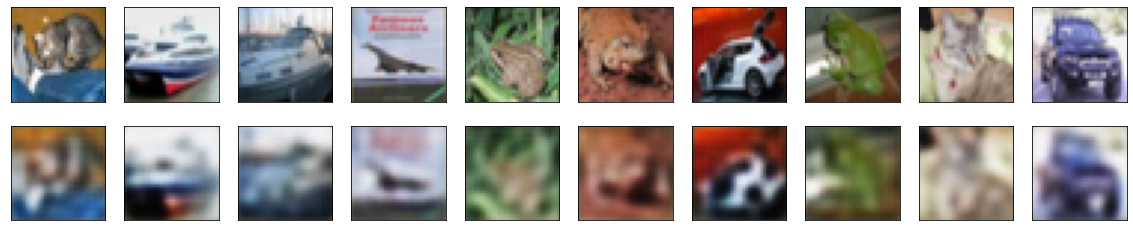

In [84]:
#predicting the validation images
decoded_imgs = autoencoder.predict(x_test)

#Plotting existing and decoded images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Question 2: Image Classification** 

**Question 2.1: Deep CNN** 

The code below sets up my CNN model. The model has two 2D convolutional layers with kernel size of 3 and stride of size 1 to adjust for the size of the image. 

We can see that the model performs okay with accuracy scores of 0.56 on training set and 0.55 on validation test. 

In [4]:
#Loading the datasets 
(xtrain,ytrain), (xtest,ytest) = cifar10.load_data() 

In [5]:
#Setting up the train and test sets 

#reshaping the image data
x_train = xtrain.astype('float32') / 255.
x_test = xtest.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

#making labels categorical
y_train = to_categorical(ytrain)
y_test = to_categorical(ytest)

In [6]:
#setting up the model
model = tfk.Sequential()
model.add(tfkl.Conv2D(filters = 64, kernel_size=3, strides=1, activation='relu', input_shape=(32, 32, 3)))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.1))

model.add(tfkl.Conv2D(filters = 32, kernel_size=3, strides=1, activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.1))

model.add(tfkl.Flatten())
model.add(tfkl.Dense(32, activation='tanh'))
model.add(tfkl.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [12]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

results = model.fit(x_train, y_train, steps_per_epoch=20, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
20/20 [==============================] - 75s 4s/step - loss: 1.6077 - accuracy: 0.4444 - val_loss: 1.4903 - val_accuracy: 0.4769
Epoch 2/10
20/20 [==============================] - 73s 4s/step - loss: 1.5078 - accuracy: 0.4715 - val_loss: 1.4237 - val_accuracy: 0.5015
Epoch 3/10
20/20 [==============================] - 76s 4s/step - loss: 1.4731 - accuracy: 0.4809 - val_loss: 1.5400 - val_accuracy: 0.4654
Epoch 4/10
20/20 [==============================] - 81s 4s/step - loss: 1.4678 - accuracy: 0.4827 - val_loss: 1.4143 - val_accuracy: 0.5050
Epoch 5/10
20/20 [==============================] - 79s 4s/step - loss: 1.4362 - accuracy: 0.4937 - val_loss: 1.3865 - val_accuracy: 0.5151
Epoch 6/10
20/20 [==============================] - 78s 4s/step - loss: 1.4139 - accuracy: 0.5026 - val_loss: 1.3585 - val_accuracy: 0.5220
Epoch 7/10
20/20 [==============================] - 76s 4s/step - loss: 1.3974 - accuracy: 0.5095 - val_loss: 1.5895 - val_accuracy: 0.4526
Epoch 8/10
20/20 [==

In [13]:
#Calculate the train accuracy levels to see how the model performed
acc_tr = model.evaluate(x_train, y_train)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_tr[0],acc_tr[1]))

1563/1563 [==============================] - 23s 15ms/step - loss: 1.2641 - accuracy: 0.5585
Test set
  Loss: 1.264
  Accuracy: 0.558


In [14]:
#Calculate the validation accuracy levels to see how the model performed
acc_ts = model.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_ts[0],acc_ts[1]))

313/313 [==============================] - 5s 15ms/step - loss: 1.2785 - accuracy: 0.5487
Test set
  Loss: 1.278
  Accuracy: 0.549


**Question 2.2: Transfer Learning** 

The code below sets up the classification model with ResNet 50 as the backbone. In additiona to resnet, I only add one dense layer that is trained on the train set.

We can see that the model performaly okay with train and validation accuracy score of 0.40. 



In [424]:
#Load the restnet package
from keras.applications import ResNet50

In [425]:
#set up the pretrained resnet50 module that will be added to the model later one
resnet = ResNet50(weights = 'imagenet' , input_shape = (32,32,3), include_top = False)
resnet.trainable = False
resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_31[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________

In [426]:
#set up the model
model2 = tfk.Sequential()

model2.add(resnet)

model2.add(tfkl.Flatten())
model2.add(tfkl.Dense(16, activation='tanh'))
model2.add(tfkl.Dense(10, activation='softmax'))

In [427]:
#summary of the model
model2.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_25 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 16)                32784     
_________________________________________________________________
dense_66 (Dense)             (None, 10)                170       
Total params: 23,620,666
Trainable params: 32,954
Non-trainable params: 23,587,712
_________________________________________________________________


In [428]:
#Complie the model
model2.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

#Fit the model on the train set and test on the validation set
results = model.fit(x_train, y_train, steps_per_epoch=20, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
20/20 [==============================] - 17s 829ms/step - loss: 1.7669 - accuracy: 0.3649 - val_loss: 1.7407 - val_accuracy: 0.3842
Epoch 2/10
20/20 [==============================] - 16s 804ms/step - loss: 1.7511 - accuracy: 0.3741 - val_loss: 1.6396 - val_accuracy: 0.4191
Epoch 3/10
20/20 [==============================] - 16s 795ms/step - loss: 1.7322 - accuracy: 0.3809 - val_loss: 1.7117 - val_accuracy: 0.3871
Epoch 4/10
20/20 [==============================] - 16s 793ms/step - loss: 1.6977 - accuracy: 0.3925 - val_loss: 1.6119 - val_accuracy: 0.4215
Epoch 5/10
20/20 [==============================] - 16s 798ms/step - loss: 1.6912 - accuracy: 0.3942 - val_loss: 1.7075 - val_accuracy: 0.3907
Epoch 6/10
20/20 [==============================] - 16s 793ms/step - loss: 1.6637 - accuracy: 0.4038 - val_loss: 1.5917 - val_accuracy: 0.4297
Epoch 7/10
20/20 [==============================] - 16s 797ms/step - loss: 1.6424 - accuracy: 0.4137 - val_loss: 1.5742 - val_accuracy: 0.4416

In [429]:
#Calculate the train accuracy levels to see how the model performed
acc_tr = model.evaluate(x_train, y_train)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_tr[0],acc_tr[1]))

1563/1563 [==============================] - 8s 5ms/step - loss: 1.7473 - accuracy: 0.4001
Test set
  Loss: 1.747
  Accuracy: 0.400


In [430]:
#Calculate the validation accuracy levels to see how the model performed
acc_ts = model.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_ts[0],acc_ts[1]))

313/313 [==============================] - 2s 5ms/step - loss: 1.7491 - accuracy: 0.3968
Test set
  Loss: 1.749
  Accuracy: 0.397


**Question 3: Text Classification** 

**Question 3.1: RNN** 

The code below preproccesses and tokenizes by cahracter the text data. It then fits a LSTM model to predict whether it is a spam or not. 

We can see that the model performs quite withh and achieves the validation accuracy of 0.98. 

In [4]:
#Attach the google drive to access the data
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [222]:
#Load the data file
file_path = "/content/gdrive/My Drive/SPAM_detection.csv"
#Read the data in
spamd = pd.read_csv(file_path)

In [223]:
#Preprocess the text to be uniform
#remove punctuation and make lowercase
spamd.Message = spamd.Message.apply(lambda x: x.lower() )
spamd.Message = spamd.Message.apply(lambda x: re.sub(r'[^\w\s]','', x) )

In [224]:
#Set up the word level tokenizer to preproces the data
tokenizer1 = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, oov_token=True)
tokenizer1.fit_on_texts(spamd.Message.values)
word_index = tokenizer1.word_index
#print('Found %s unique tokens.' % len(word_index))

Found 9581 unique tokens.


In [225]:
#Tokenize the text and turn the lables into a usable array
X = tokenizer1.texts_to_sequences(spamd.Message.values)
X = pad_sequences(X, maxlen=250)
print('Shape of data tensor:', X.shape)

Y = np.array(spamd.category_val)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (5572, 250)
Shape of label tensor: (5572,)


In [226]:
#Split the tokenized data into train and test sets
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X,Y, test_size = 0.2)

In [227]:
#Set up the LSTM model below 
model = Sequential()
model.add(Embedding(10000,250,input_length = X.shape[1]))
model.add(tfkl.LSTM(100, dropout = 0.2))
model.add(tfkl.Dense(1,activation="sigmoid"))

In [228]:
#Compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(X_train1,Y_train1, validation_data = (X_test1, Y_test1), epochs=5, batch_size=64)

Epoch 1/5
70/70 [==============================] - 51s 736ms/step - loss: 0.2343 - accuracy: 0.9221 - val_loss: 0.0651 - val_accuracy: 0.9821
Epoch 2/5
70/70 [==============================] - 52s 738ms/step - loss: 0.0423 - accuracy: 0.9892 - val_loss: 0.0511 - val_accuracy: 0.9821
Epoch 3/5
70/70 [==============================] - 51s 735ms/step - loss: 0.0157 - accuracy: 0.9966 - val_loss: 0.0540 - val_accuracy: 0.9848
Epoch 4/5
70/70 [==============================] - 51s 736ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.0694 - val_accuracy: 0.9821
Epoch 5/5
70/70 [==============================] - 51s 726ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0602 - val_accuracy: 0.9865


In [229]:
#Calculate the validation accuracy levels to see how the model performed
accur = model.evaluate(X_test1, Y_test1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accur[0],accur[1]))

35/35 [==============================] - 4s 111ms/step - loss: 0.0602 - accuracy: 0.9865
Test set
  Loss: 0.060
  Accuracy: 0.987


The code below calculates the false positive and true positive rates ahead of plotting the ROC curve.

In [230]:
#Calculate the predictions and false and true positive rates for plottin
y_pred1 = model.predict(X_test1)
fpr1, tpr1, thresholds1 = roc_curve(Y_test1, y_pred1)

**Question 3.2: CNN** 

The code below preproccesses and tokenizes by cahracter the text data. It then fits a 1D CNN model to predict whether it is a spam or not. 

We can see that the model performs quite withh and achieves the validation accuracy of 0.98. 

In [244]:
#Load the fila
file_path = "/content/gdrive/My Drive/SPAM_detection.csv"
#Read in the data
spamd = pd.read_csv(file_path)

In [245]:
#Preprocess the text to be uniform
#remove punctuation and make lowercase
spamd.Message = spamd.Message.apply(lambda x: x.lower() )
spamd.Message = spamd.Message.apply(lambda x: re.sub(r'[^\w\s]','', x) )

In [246]:
#This function splits each message by character ahead of tokanizing
def concat_list(l):
    concat = ''
    for word in l:
        concat += word + ' '
    return concat
#Apply the function to the messages ahead of tokanizing the allow for character level tokenization
spamd.Message = [concat_list(data) for data in spamd.Message]

In [247]:
#Set up the character level tokenizer to preproces the data
tokenizer2 = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, char_level = True, oov_token=True)
tokenizer2.fit_on_texts(spamd.Message.values)

In [248]:
#Tokenize the text and turn the lables into a usable array
X = tokenizer2.texts_to_sequences(spamd.Message.values)
X = pad_sequences(X, maxlen=250)
print('Shape of data tensor:', X.shape)

Y = np.array(spamd.category_val)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (5572, 250)
Shape of label tensor: (5572,)


In [249]:
#Split the tokenized data into train and test sets
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X,Y, test_size = 0.2)

In [250]:
#Set up the 1D CNN model below 
model2 = Sequential()

model2.add(Embedding(10000,250,input_length=X_train2.shape[1]))
model2.add(layers.Conv1D(32,5,activation='tanh'))
model2.add(tfkl.MaxPooling1D(100, strides=5))
model2.add(layers.Conv1D(32,5,activation='tanh'))
model2.add(tfkl.GlobalMaxPooling1D())
model2.add(layers.Dense(1, activation ='sigmoid'))

In [251]:
#Compile and fit the model
model2.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])
model2.fit(X_train2,Y_train2, validation_data = (X_test2, Y_test2), epochs=5, batch_size=64)

Epoch 1/5
70/70 [==============================] - 15s 214ms/step - loss: 0.2046 - accuracy: 0.9260 - val_loss: 0.0800 - val_accuracy: 0.9740
Epoch 2/5
70/70 [==============================] - 15s 213ms/step - loss: 0.0919 - accuracy: 0.9708 - val_loss: 0.0699 - val_accuracy: 0.9812
Epoch 3/5
70/70 [==============================] - 15s 214ms/step - loss: 0.0761 - accuracy: 0.9776 - val_loss: 0.0624 - val_accuracy: 0.9821
Epoch 4/5
70/70 [==============================] - 15s 214ms/step - loss: 0.0683 - accuracy: 0.9803 - val_loss: 0.0545 - val_accuracy: 0.9839
Epoch 5/5
70/70 [==============================] - 16s 223ms/step - loss: 0.0638 - accuracy: 0.9805 - val_loss: 0.0584 - val_accuracy: 0.9803


In [252]:
#Calculate the validation accuracy levels to see how the model performed
accur = model2.evaluate(X_test2, Y_test2)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accur[0],accur[1]))

35/35 [==============================] - 1s 21ms/step - loss: 0.0584 - accuracy: 0.9803
Test set
  Loss: 0.058
  Accuracy: 0.980


The code below calculates the false positive and true positive rates ahead of plotting the ROC curve.

In [254]:
#Calculate the predictions and false and true positive rates for plotting
y_pred2 = model2.predict(X_test2)
fpr2, tpr2, thresholds2 = roc_curve(Y_test2, y_pred2)

**Question 3.3: Comparison** 

The code below calculates the area under the ROC curve for both models and plots their respective ROC curves.   

We can see that the 1D CNN model achieved slightly better results in accuracy as compared to the LSTM model. However, both achieved really exceptional validation accuracy levels. 

In [255]:
#Calculating area under the curve for LSTM
auc1 = auc(fpr1, tpr1)
#Calculating area under the curve for CNN
auc2 = auc(fpr2, tpr2)

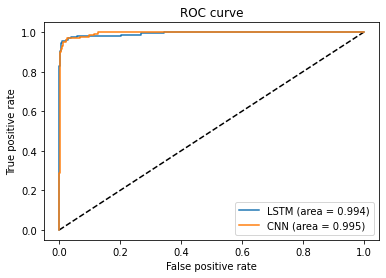

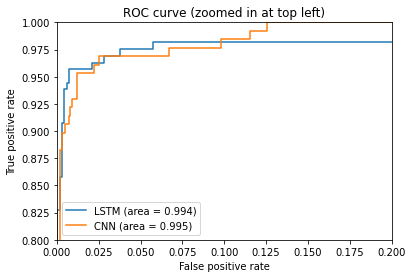

In [256]:
#Plotting the ROC curve for both models
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LSTM (area = {:.3f})'.format(auc1))
plt.plot(fpr2, tpr2, label='CNN (area = {:.3f})'.format(auc2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Plotting a zoom in of the top left corner to show the difference in ROC
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LSTM (area = {:.3f})'.format(auc1))
plt.plot(fpr2, tpr2, label='CNN (area = {:.3f})'.format(auc2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()